<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/Primitives_%7C_Coding_with_Qiskit_1_x_%7C_Programming_on_Quantum_Computers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install qiskit[visualization]
!python3 -m pip install qiskit-ibm-runtime
!python3 -m pip install qiskit_aer

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", # ibm Cloud
                               token="65f433e4c277ef8574de6e2ab4844d80fc16b655c737fcce989a65d0ad405ecada95eab703025e49985474a16bb8db0729a9a99fea96130d6dd1ecaa4adae281")

In [3]:
QiskitRuntimeService.save_account(channel="ibm_quantum", # ibm Cloud
                               token="65f433e4c277ef8574de6e2ab4844d80fc16b655c737fcce989a65d0ad405ecada95eab703025e49985474a16bb8db0729a9a99fea96130d6dd1ecaa4adae281",
                               overwrite=True)

In [4]:
service = QiskitRuntimeService(instance='ibm-q/open/main')
backends = service.backends()
backends = service.backends(simulator=True, min_num_qubits=5)
print(backends)

[<IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>]


In [5]:
from qiskit_aer import AerSimulator

#Transverse field Ising model to demo primitives

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

In [7]:
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers = False, layer_barriers = False):

  if num_cl_bits == 0:
    qc = QuantumCircuit(num_qubits)
  else:
    qc = QuantumCircuit(num_qubits, num_cl_bits)
  ###if

  for trotter_step in range(num_trotter_steps):
    add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

  return qc
###def

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  # Adding Rzz in the even layers
  for i in range(0, qc.num_qubits-1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  for i in range(1, qc.num_qubits-1, 2):
    qc.sdg([i, i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  qc.rx(rx_angle, list(range(qc.num_qubits)))

  if layer_barriers:
    qc.barrier()
  ###if
###def

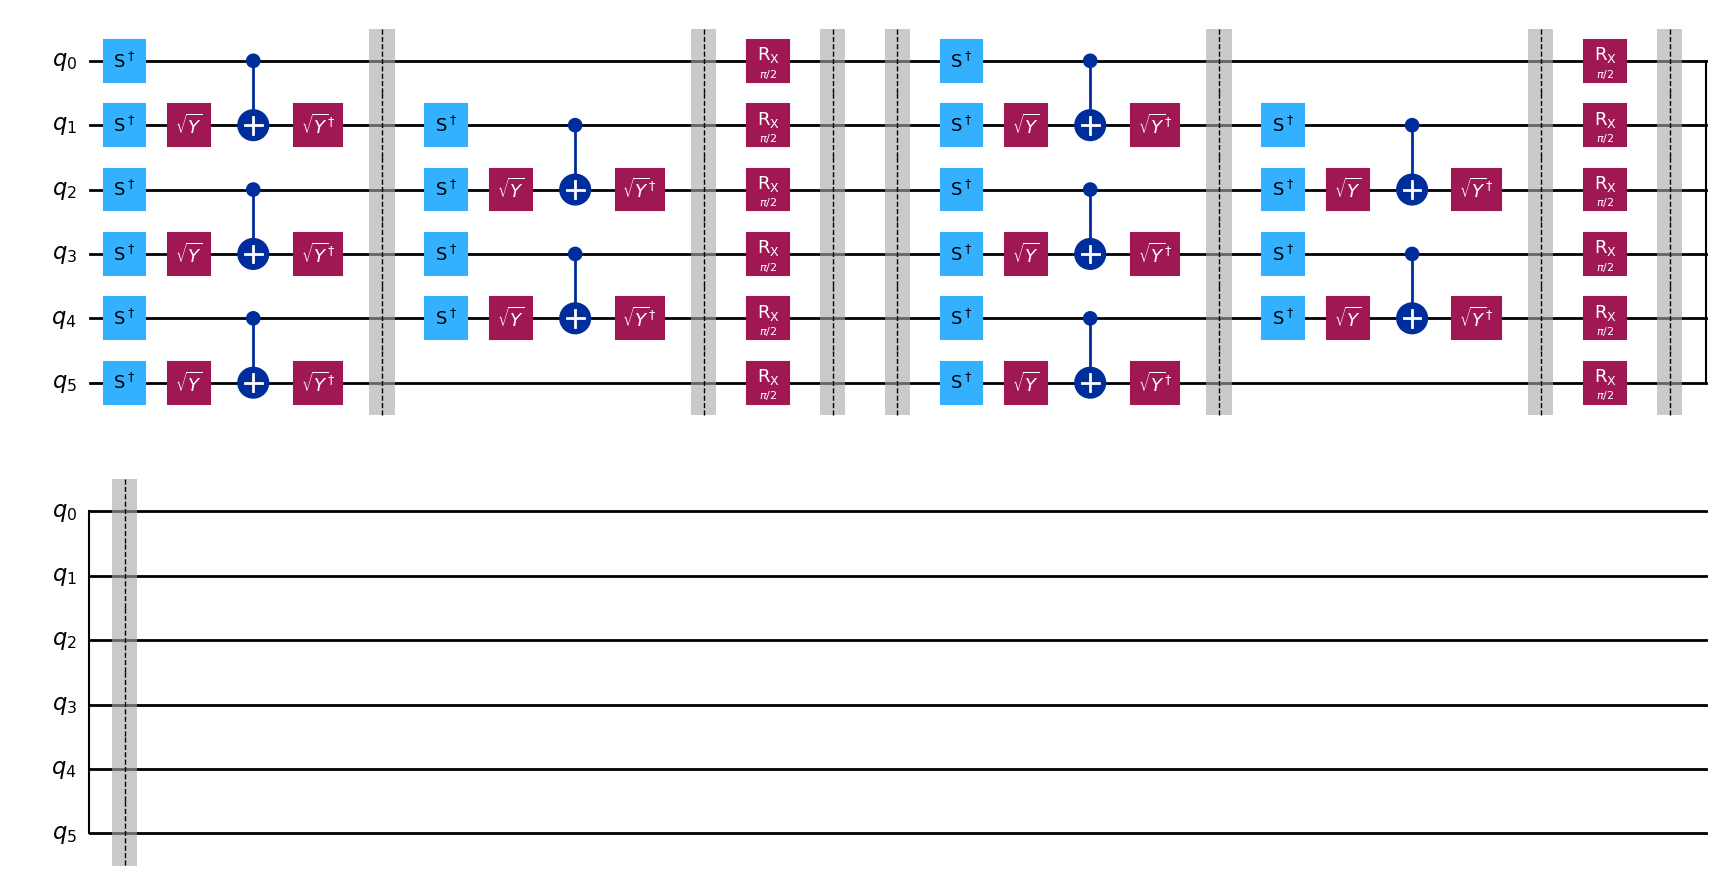

In [8]:
num_qubits = 6
num_trotter_steps = 2
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl')

# Demo: Sampler

In [9]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

  for trotter_step in range(num_trotter_steps):
    add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if trotter_barriers:
      qc.barrier()
    ###if
  ###for

  return qc
###def

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  qc.rx(-rx_angle, list(range(qc.num_qubits)))
  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the even layers
  for i in range(1, qc.num_qubits-1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.sdg([i, i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if

  # Adding Rzz in the even layers
  for i in range(0, qc.num_qubits-1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.sdg([i, i+1])
  ###for
  if layer_barriers:
    qc.barrier()
  ###if
###def

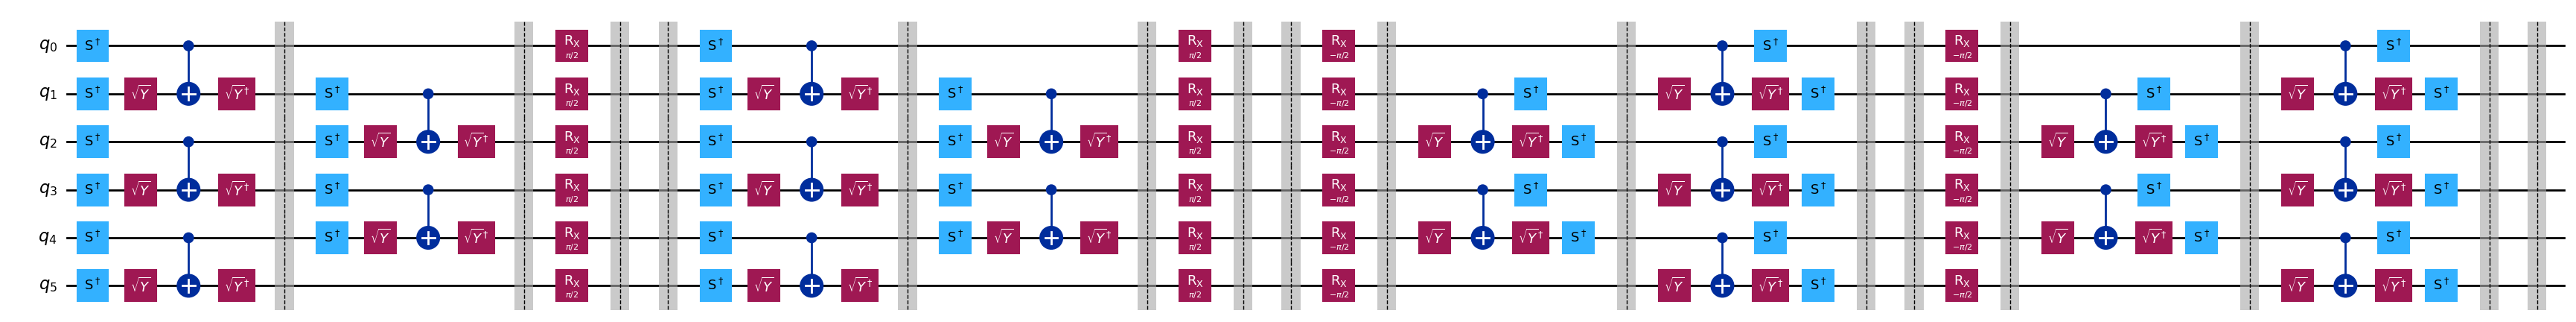

In [10]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

# Step 1: map the problem to circuits and observables

In [11]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
  qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
  append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
  qc.measure(measured_qubits, list(range(len(measured_qubits))))
  qc_list.append(qc)
###for

In [12]:
#qc_list[1].draw(output='mpl')

# Step 2: Optimize

In [13]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

#backend_name = "ibm_brisbane"
backend_name = "simulator_mps"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print("Done getting the backend")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

Done getting the backend


#Step 3: Execute on hardware

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

colk8aj501i0h3e7tlp0


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators have been deprecated and will be removed on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


# Step 4: Post-processing and plotting

In [15]:
job_id = "colk8aj501i0h3e7tlp0"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
  try:
    data = job.result()[trotter_step].data
    survival_probability_list.append(data.c.get_counts()['0' * len(measuered_qubits)] / data.c.num_shots)
  except:
    survival_probability_list.append(0)
  ###try
###for

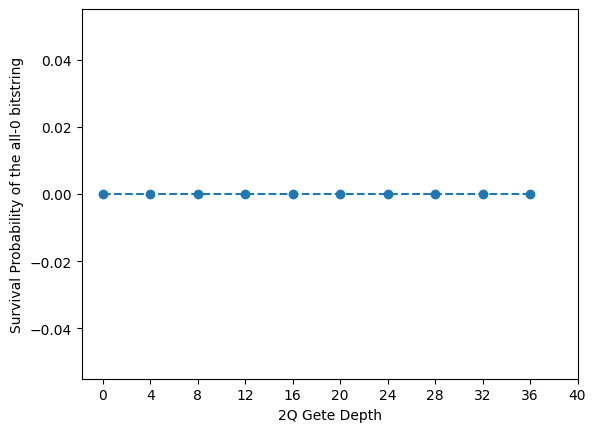

In [16]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gete Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()


##Estimator
#Step 1: Mapping the problem

In [17]:
from qiskit.circuit import Parameter
rx_angle = Parameter("rx_angle")
trotter_steps = 2

qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
obserable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

#Setp 2: Optimize the circuit

In [20]:
from qiskit import transpile
from qiskit_ibm_runtime import qiskit_runtime_service

backend_name = 'simulator_mps'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level = 1)

observable = observable.apply_layout(qc_transpiled.layout)

NameError: name 'observable' is not defined

# Step 3: Execute on Quantim Hardware

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decopuling.sequence_type = "XY4"

estimator = EstimatorV2(backend=backend, options=options)

job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())

#Step 4: Post-processing and plotting

In [ ]:
job_id = "crnjw3r0250g0084spt0"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle in the middle of the chain')
plt.ylim(-0.1, 1.1)